# Observer

This Observer notebook monitors USB cameras for changes on the DMA playing field.

In [1]:
import json
import cv2
from collections import defaultdict
import numpy as np
import imutils
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode as qrDecode
from math import cos, acos, degrees, radians
from time import sleep
from datetime import datetime
import requests
from dataclasses import dataclass
from traceback import format_exc

In [2]:
@dataclass
class CamCoordinate:
    x: int
    y: int
    

@dataclass
class RealCoordinate:
    x: float
    y: float

In [3]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel("FSRCNN_x4.pb")
sr.setModel("fsrcnn", 4);


def distanceFormula(pt0, pt1):
    return sum([(b - a)**2 for a, b in zip(pt0, pt1)]) ** 0.5


def capture_camera(cam_num):
    try:
        cam = cv2.VideoCapture(cam_num)
        retval, image = cam.read()
    finally:
        cam.release()
    retval, buff = cv2.imencode('.jpg', image)
    return buff


MAX_CAM_ID = 10


def identify_usb_cameras(device_numbers=list(range(MAX_CAM_ID))):
    functional = []
    for dn in device_numbers:
        try:
            img = capture_camera(dn)
            functional.append(dn)
        except Exception as e:
            continue
    return functional


def hStackImages(images):
    if len(images) == 0:
        return np.zeros((1, 1), dtype="uint8")
    baseIm = None
    maxHeight = max([im.shape[0] for im in images])
    for im in images:    
        if im.shape[0] < maxHeight:
            addition = np.zeros((maxHeight - im.shape[0], im.shape[1], 3), np.uint8)
            im = np.vstack((im, addition))
        if baseIm is None:
            baseIm = im
        else:
            baseIm = np.hstack((
                baseIm,
                np.zeros((maxHeight, 10, 3), np.uint8),
                im))
    return baseIm

In [4]:
@dataclass
class CameraChange:
    changePoints: np.array
    center: np.array
    width: int
    height: int
    before: np.array
    after: np.array
    
    def __repr__(self):
        return f"{self.center} by {self.width},{self.height}"
    
    def __eq__(self, other):
        return sum([(cD - pD) ** 2 for cD, pD in np.vstack([self.center, other.center]).T]) ** 0.5 < 25
    
    def beforeAfter(self):
        return hStackImages([self.before, self.after])

In [5]:
@dataclass
class Camera:
    camNum: int
    activeZone: list
    
    IMAGE_BUFFER_DEPTH = 7
    CAPTURE_FRAMES = 3
    xmax = 2560
    ymax = 1920

    def __post_init__(self):
        self.referenceFrame = None
        self.baseFrame = None
    
    @property
    def mostRecentFrame(self):
        return self.imageBuffer[0]
    
    def setBaseFrame(self):
        self.baseFrame = self.mostRecentFrame
    
    def setReferenceFrame(self):
        self.referenceFrame = self.mostRecentFrame
    
    def setActiveZone(self, newAZ):
        self.activeZone = np.float32(newAZ)

    def __post_init__(self):
        self.imageBuffer = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.imageDeltas = [None for i in range(self.IMAGE_BUFFER_DEPTH)]
        self.setActiveZone(self.activeZone)
        self.minimumWidth = 100
        self.referenceFrame = None
    
    def pointInActiveZone(self, p):
        return cv2.pointPolygonTest(self.activeZone, p, False) >= 0
    
    def collectImage(self) -> np.ndarray:
        cap = cv2.VideoCapture(self.camNum)
        sleep(delay)
        image = None
        try:
            for frame in range(self.CAPTURE_FRAMES):
                ret, cv2_im = cap.read()
                sleep(delay)
            image = sr.upsample(cv2_im)
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        finally:
            cap.release()
        return image
    
    @staticmethod
    def contoursBetween(im0, im1):
        if im0 is None or im1 is None:
            return []
        img_height = im0.shape[0]
        diff = cv2.absdiff(cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))
        thresh = cv2.threshold(diff,64,255,cv2.THRESH_BINARY)[1]
        kernel = np.ones((5,5), np.uint8) 
        dilate = cv2.dilate(thresh, kernel, iterations=2)
        return cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    @classmethod
    def detectObjectsKMeans(cls, contours, beforeIm, afterIm):
        allPoints = np.array([pt for c in contours for d in c for pt in d], dtype="float32")
        kResults = {}
        for k in range(1, 5):
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            ret,label,center=cv2.kmeans(allPoints,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            groups = [[] for i in range(k)]
            dims = []
            heights = []
            classified = []
            wss = []
            for i in range(len(label)):
                groups[label[i][0]].append(allPoints[i])
                classified.append(allPoints[i])
                wss.append(sum([(cD - pD) ** 2 for cD, pD in np.vstack([center[label[i][0]], allPoints[i]]).T]))
            
            objects = []
            for center, group in zip(center, groups):
                cx, cy = center
                height = max([p[1] for p in group]) - cy
                width = max([p[0] for p in group]) - cx
                clipHeight = height * 1.3
                clipWidth = width * 1.3
                beforeClip = beforeIm[int(cy - clipHeight): int(cy + clipHeight), int(cx - clipWidth): int(cx + clipWidth)]
                afterClip = afterIm[int(cy - clipHeight): int(cy + clipHeight), int(cx - clipWidth): int(cx + clipWidth)]
                objects.append(CameraChange(group, center, width, height, beforeClip, afterClip))

            wss = (sum(wss) ** 0.5) * k
            kResults[k] = (objects, wss)
        objectsByWss = {kR[1]: kR[0] for kR in kResults.values()}
        objects = objectsByWss[min(objectsByWss)]
        return objects
    
    def changeSet(self, depth=3):
        avgDiff = None
        for i in range(depth):
            diff = cv2.absdiff(cv2.cvtColor(self.referenceFrame, cv2.COLOR_BGR2GRAY),
                               cv2.cvtColor(self.imageBuffer[i], cv2.COLOR_BGR2GRAY))
            diff = self.maskFrameToActiveZone(diff)
            thresh = cv2.threshold(diff, 64, 255, cv2.THRESH_BINARY)[1]
            if avgDiff is None:
                avgDiff = thresh
            else:
                avgDiff = cv2.bitwise_and(avgDiff, thresh)
        kernel = np.ones((5,5), np.uint8) 
        dilate = cv2.dilate(avgDiff, kernel, iterations=2)
        contours, _ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        newIm = self.imageBuffer[0].copy()
        oldIm = self.referenceFrame.copy()
        boxes = []
        largeContours = []
        newClips = []
        oldClips = []
        
        filteredContours = []
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            x, y, w, h = bRect
            centerPoint = [x + int(w/2), y + int(h/2)]
            area = w * h
            if 500000 > area > 1500 and self.pointInActiveZone(centerPoint):
                filteredContours.append(contour)
        if len(filteredContours) > 0:
            newIm = cv2.drawContours(newIm, filteredContours, -1, (255, 0, 0), 3)
            oldIm = cv2.drawContours(oldIm, filteredContours, -1, (255, 0, 0), 3)
            objects = self.detectObjectsKMeans(filteredContours, beforeIm=oldIm, afterIm=newIm)
            return objects
        else:
            return []
    
    def capture(self):
        self.collectImage()
    
    def cropToActiveZone(self, image):
        pts = np.int32(self.activeZone)
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
        dst = cv2.bitwise_and(image, image, mask=mask)
        return dst
        
    def drawActiveZone(self, image):
        pts = np.int32(self.activeZone)
        azOverlaidImage = image.copy()
        return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(0,255,0), thickness=5)

    def maskFrameToActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        mask = np.zeros((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(mask, [np.array(self.activeZone, np.int32)], 255)
        return cv2.bitwise_and(frame, frame, mask=masked)
    
    def maskFrameToNonActiveZone(self, frame=None):
        frame = self.mostRecentFrame if frame is None else frame
        zeroes = np.ones((frame.shape[:2]), dtype="uint8")
        masked = cv2.fillPoly(zeroes, [np.array(self.activeZone, np.int32)], 0)
        return cv2.bitwise_and(frame, frame, mask=masked)

    def interactionDetection(self, comparisonImage):
        interactionSizeThreshold = 50000
        baseImage = self.referenceFrame.copy()
        contours = self.contoursBetween(baseImage, comparisonImage)
        for contour in contours:
            bRect = cv2.boundingRect(contour)
            bRectArea = bRect[-1] * bRect[-2]
            if bRectArea < interactionSizeThreshold:
                continue
            zeros = np.zeros((baseImage.shape[:2]), dtype="uint8")
            drawnContour = cv2.drawContours(zeros, [contour], 0, 255, 3)
            if self.maskFrameToActiveZone(drawnContour).any() and self.maskFrameToNonActiveZone(drawnContour).any():
                return True
        return False

    @classmethod
    def drawBoxesOnImage(cls, image, boxes, color=(0,0,255)):
        imageWithBoxes = image.copy()
        for x, y, w, h in boxes:
            cv2.rectangle(imageWithBoxes, (x, y), (x+w, y+h), color, 2)
            presumedBasePoint = [x + int(w/2), y + int(h/2)]
            cv2.circle(imageWithBoxes, presumedBasePoint, radius=4, thickness=4, color=(0,255,255))
            cv2.putText(imageWithBoxes, f'{w*h}p-[{x}-{x+w}, {y}-{y+w}]', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
        return imageWithBoxes
    
    @staticmethod
    def swapBox(srcIm, dstIm, box):
        swapped = dstIm.copy()
        x, y, w, h = box
        orig = srcIm[y:y+h, x:x+w]
        swapped[y:y+h, x:x+w] = orig
        return swapped
    
    @staticmethod
    def getAngle(pt0, pt1, pt2):
        u = [pt1[0] - pt0[0], pt1[1] - pt0[1]]
        v = [pt2[0] - pt0[0], pt2[1] - pt0[1]]

        duv = u[0] * v[0] + u[1] * v[1]
        mu = (u[0] ** 2 + u[1] ** 2) ** 0.5
        mv = (v[0] ** 2 + v[1] ** 2) ** 0.5
        return degrees(acos( duv / (mu * mv) ))

    @classmethod
    def calibrationTriangleToRealCoordinates(cls, triPts):
        angles = {}
        for idx, pt in enumerate(triPts):
            vectors = []
            otherPts = [op for op in triPts if not (pt == op).all()]
            angles[idx] = cls.getAngle(pt, *otherPts)

        ninetyPt = triPts[sorted([(key, abs(90 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        sixtyPt = triPts[sorted([(key, abs(60 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]
        thirtyPt = triPts[sorted([(key, abs(30 - angle)) for key, angle in angles.items()], key=lambda x: x[1])[0][0]]

        ninetyThirtyDiff = [d1 - d0 for d1, d0 in zip(thirtyPt, ninetyPt)]
        missingPt = np.float32([pt + d for pt, d in zip(sixtyPt, ninetyThirtyDiff)])

        cameraPts = np.float32([ninetyPt, sixtyPt, missingPt, thirtyPt])
        realPts = np.float32([[500, 500], [538.5, 500], [538.5, 525], [500, 525]])

        return cameraPts, realPts

    def tuneToCalibrationBox(self, observedCorners, unwarpedCorners):
        self.M = cv2.getPerspectiveTransform(observedCorners, unwarpedCorners)

    def calibrate(self, trianglePts):
        cameraPts, realPts = self.calibrationTriangleToRealCoordinates(trianglePts)
        self.tuneToCalibrationBox(cameraPts, realPts)

    def convertCameraToRealSpace(self, p):
        assert not (self.M is None), "Must calibrate camera before converting coordinates"
        M = self.M
        px = (M[0][0]*p[0] + M[0][1]*p[1] + M[0][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        py = (M[1][0]*p[0] + M[1][1]*p[1] + M[1][2]) / ((M[2][0]*p[0] + M[2][1]*p[1] + M[2][2]))
        return (px, py)
    
    @staticmethod
    def distanceFormula(pt0, pt1):
        return sum([(b - a)**2 for a, b in zip(pt0, pt1)]) ** 0.5
    
    def cameraPointsToRealDistance(self, pt0, pt1):
        """ Calculates distance between cam's RealSpace coordinates to distance in mm """
        ptr0 = cam0.convertCameraToRealSpace(pt0)
        ptr1 = cam0.convertCameraToRealSpace(pt1)
        return self.distanceFormula(ptr0, ptr1) * CalibrationBox.millimetersPerPixel
        
    def showUnwarpedImage(self):
        warp = cv2.warpPerspective(self.cropToActiveZone(self.mostRecentFrame), self.M, (1000, 1000))
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(warp)
        plt.show()
        return warp

In [6]:
@dataclass
class RemoteCamera(Camera):
    address: str
    rotate: bool = False

    def collectImage(self) -> np.ndarray:
        image = None
        try:
            for i in range(5):
                resp = requests.get(self.address, stream=True).raw
                image = np.asarray(bytearray(resp.read()), dtype="uint8")
                image = cv2.imdecode(image, cv2.IMREAD_COLOR)
                if self.rotate:
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
                if image is not None:
                    break
            assert image is not None, f"Failed to collect image for Camera {self.camNum}"
            
            self.imageBuffer.insert(0, image)
            self.imageBuffer.pop()
        except Exception as e:
            print(f"Failed to capture Camera: {e}")
        return image

In [7]:
@dataclass
class CaptureConfiguration:
    name: str
    
    def __post_init__(self):
        self.lastCapture = None
    
    def capture(self):
        self.lastCapture = {cam.camNum: cam.capture() for cam in cameras.values()}

    def setBase(self):
        for c in cameras.values():
            c.setBaseFrame()
    
    def setReference(self):
        for c in cameras.values():
            c.setReferenceFrame()
    
    def scanCamsForCalibrationBoxes(self):
        return {cam.camNum: (qrs := decode(cam.mostRecentFrame), len(qrs)) for cam in cameras.values()}
    
    def saveConfiguration(self):
        state = {
            camNum: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist()),
                "mw": cam.minimumWidth,
                "m": json.dumps(cam.M.tolist()) if cam.M is not None else None}
            for camNum, cam in cameras.items()}
        state["pov"] = {
            "addr": pov.address,
            "rot": pov.rotate
        }
        with open("observerConfiguration.json", "w") as f:
            f.write(json.dumps(state, indent=2))
            
    def recoverConfiguration(self):
        with open("observerConfiguration.json", "r") as f:
            state = json.loads(f.read())
        for camNum, camDef in state.items():
            if str(camNum) == "pov":
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = RemoteCamera(address=addr, rotate=rot, activeZone=[], camNum=-99)
            else:
                addr = camDef['addr']
                az = np.float32(json.loads(camDef['az']))
                cameras[int(camNum)] = RemoteCamera(address=addr, activeZone=az, camNum=int(camNum))
                cameras[int(camNum)].M = None if camDef['m'] is None else np.float32(json.loads(camDef['m']))

In [8]:
@dataclass
class Capture:
    cid: str
    changeSet: dict[int, CameraChange]
    
    def __eq__(self, other):
        if len(self.changeSet) != len(other.changeSet):
            return False

        for camNum, change in self.changeSet.items():
            if camNum not in other.changeSet or change != other.changeSet[camNum]:
                return False
        return True
    
    def changeOverlap(self, camNum: int, change: CameraChange):
        if camNum not in self.changeSet:
            return False
        
        cam = cameras[camNum]
        camChange = self.changeSet[camNum]
        changeContour = np.array([camChange.changePoints], dtype=np.int32)
        otherContour = np.array([change.changePoints], dtype=np.int32)
        zeros = np.zeros(cam.mostRecentFrame.shape[:2], np.uint8)
        changeIm = cv2.drawContours(zeros.copy(), changeContour, -1, 255, -1)
        otherIm = cv2.drawContours(zeros.copy(), otherContour, -1, 255, -1)
        return cv2.bitwise_and(changeIm, otherIm).any()
    
    def visual(self):
        return hStackImages([cs.after for cs in self.changeSet.values()])
    
    def realCoordinate(self):
        return list(self.changeSet.values())[0].center


class CaptureMemory:
    def __init__(self, captures=None):
        self.captures = captures if captures is not None else {}
        
    def memorize(self, changeSet):
        captureInteractions = []
        for cam, changes in changeSet.items():
            for change in changes:
                for capture in self.captures.values():
                    if capture not in captureInteractions and capture.changeOverlap(cam, change):
                        captureInteractions.append(capture)
        maxChangesPerCam = max([len(changes) for changes in changeSet.values()])
        # If changeSet has 1 change or less per camera and no interactions -- new Capture
        if len(captureInteractions) == 0 and maxChangesPerCam == 1:
            captureSet = {camNum: change
                          for camNum, changes in changeSet.items()
                          for change in changes}
            objectName = f"obj{len(self.captures)}"
            self.captures[objectName] = Capture(objectName, captureSet)
            print(f"Added Object {objectName}")
        # If changeSet has 1 change or less per camera and 1 interactions -- Capture Alter
        elif len(captureInteractions) == 1 and maxChangesPerCam == 1:
            origCapture = captureInteractions[0]
            captureSet = {camNum: change
                          for camNum, changes in changeSet.items()
                          for change in changes}
            origCapture.changeSet = captureSet
            print(f"Altered Object {origCapture.cid}")
        # If a changeSet has 2 changes or less per camera and interacts with 1 object leaving 1 shadow -- moved Capture
        elif len(captureInteractions) == 1:
            origCapture = captureInteractions[0]
            startPosition = origCapture.changeSet
            leftOver = {camNum: change
                        for camNum, changes in changeSet.items()
                        for change in changes if camNum not in startPosition or startPosition[camNum] != change}
            origCapture.changeSet = leftOver
            print(f"Moved {origCapture.cid} from {startPosition} to {leftOver}")
        else:
            raise Exception(f"Unable to parse cI: {len(captureInteractions)} || mC: {maxChangesPerCam} || changeSet: {changeSet}\n{format_exc()}")

In [9]:
class CaptureMachine:
    """ Camera Capture State Machine, primary loop:
                                 {on interaction detection} --> (interaction)            
                                 /                                      |
                __init__ ---> (idle)                                    V
                                  ^------- (observation) <--------- (debounce)
            
    """
    states = ["idle", "interaction", "debounce", "observation", "error"]
    mode = ["terrain", "add_unit", "move_unit"]
    observationThreshold = 3
    def __init__(self, captureConfiguration: CaptureConfiguration):
        self.cc = captureConfiguration
        self.mode = "unit"
        self.cc.capture()
        self.cc.setBase()
        self.cc.setReference()
        self.state = "idle"
        self.interactionDetected = False
        self.nextState = self.next_state()
        self.debounceCounter = 0
        self.cycleCounter = 0
        self.changes = {}
        self.memory = CaptureMemory()
        
    def __repr__(self):
        return f"CapMac -- {self.state}\nMode: {self.mode}\nID: {self.interactionDetected} | DC: {self.debounceCounter}"
    
    def next_state(self):
        if self.state == "idle":
            print(f"Saw interaction? {self.interactionDetected}")
            if self.interactionDetected:
                print("woo")
                return "interaction"
            else:
                return "idle"
        elif self.state == "interaction":
            print(f"Saw interaction? {self.interactionDetected}")
            if self.interactionDetected:  # TODO: add depth
                return "interaction"
            else:
                return "debounce"
        elif self.state == "debounce":
            print(f"Saw interaction? {self.interactionDetected}")
            print(f"Debounce counter: {self.debounceCounter}")
            if self.interactionDetected:
                return "interaction"
            elif self.debounceCounter > self.observationThreshold:
                return "observation"
            else:
                return "debounce"
        elif self.state == "observation":
            return "idle"
        else:
            return "error"

    def changeSet(self, depth=3):
        return {camNum: camera.changeSet(depth=depth)
                for camNum, camera in cameras.items()}

    def execute_state(self):
        if self.state == "idle":
            if not self.interactionDetected:
                print("Setting reference")
                self.cc.setReference()
        elif self.state == "interaction":
            self.debounceCounter = 0
        elif self.state == "debounce":
            self.debounceCounter += 1
        elif self.state == "observation":
            changeSet = self.changeSet(depth=self.observationThreshold)
            allChanges = [c for cam in changeSet.values() for c in cam]
            if len(allChanges) > 0:
                print(f"Memorizing changes on cycle {self.cycleCounter}: {changeSet}")
                self.changes[self.cycleCounter] = changeSet
                self.memory.memorize(changeSet)
            self.cc.setReference()
        self.cycleCounter += 1
    
    def interactionDetection(self):
        detections = {cam.camNum: cam.interactionDetection(cam.mostRecentFrame) for cam in cameras.values()}
        return sum(detections.values()) > 0

    def cycle(self):
        print(f"Starting Cycle {self.cycleCounter} -- S:{self.state}")
        self.cc.capture()
        self.interactionDetected = self.interactionDetection()
        self.execute_state()
        self.state = self.next_state()
        print(f"Cycle complete. Transitioning to {self.state}\n")
    
    def calibrate(self):
        for i in range(5):
            self.cc.capture()
        changeSet = {camNum: change
                     for camNum, camChanges in self.changeSet(depth=self.observationThreshold).items()
                     for change in camChanges}
        for camNum, cam in cameras.items():
            c = changeSet[camNum]
            changeContour = np.array([c.changePoints], dtype=np.int32)
            peri = cv2.arcLength(changeContour, True)
            approx = cv2.approxPolyDP(changeContour, 0.04 * peri, True)
            assert len(approx) == 3, "Triangle not recognized"
            triPts = [pt[0] for pt in approx]
            cam.calibrate(triPts)
        
    def unwarpedOverlaidCameras(self):
        im = None
        for camNum, cam in cameras.items():
            warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), cam.M, (1000, 1000))
            im = warp if im is None else cv2.addWeighted(im, 0.6, warp, 0.3, 0)
        return im

In [14]:
cameras = defaultdict(lambda x: None)
pov = None
cc = CaptureConfiguration(__name__)
cc.recoverConfiguration()
cm = CaptureMachine(cc)

Saw interaction? False


In [11]:
if __name__ == "__main__":
    cm.calibrate()
    print({camNum: cam.M for camNum, cam in cameras.items()})

KeyError: 0

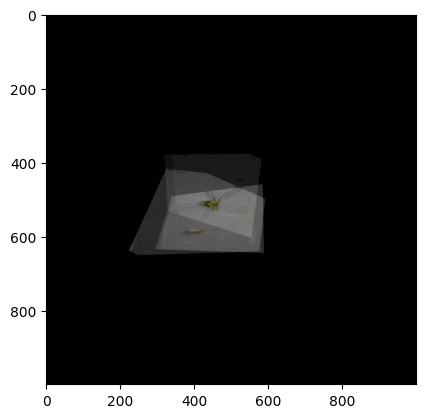

In [18]:
if __name__ == "__main__":
    def unwarpedView():
        im = None
        for camNum, cam in cameras.items():
            warp = cv2.warpPerspective(cam.cropToActiveZone(cam.mostRecentFrame), cam.M, (1000, 1000))
            im = warp if im is None else cv2.addWeighted(im, 0.6, warp, 0.3, 0)
        return im
    plt.imshow(unwarpedView())

Starting Cycle 50 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 51 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 52 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 53 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 54 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 55 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 56 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 57 -- S:idle
Setting reference
Saw interaction? False
Cycle complete. Transitioning to idle

Starting Cycle 58 -- S:idle
Saw interaction? True
woo
Cycle complete. Transitioning to interaction

Starting Cycle 59 -- S:interaction
S

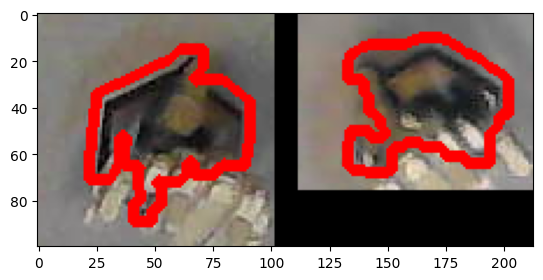

In [17]:
if __name__ == "__main__":
    for i in range(50):
        cm.cycle()
        
    print(cm.memory.captures)
    plt.imshow(cm.memory.captures['obj0'].visual())